In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

from pipeline.python.classifications import decode_utils as dutils

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'
response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)


#### Experiment to decode
experiment = 'blobs'
stim_filterby = 'first'
has_gratings = False


dff_resptest-nstds_respthr-10.00


# Output dir

In [5]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Get metadata for experiment type

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,26
Lm,22
V1,18


# Exclude datasets without RFs

In [7]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,13
Lm,12
V1,11


# Drop duplicates and whatnot fovs

In [8]:
if experiment=='blobs':
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, 
                                       has_gratings=has_gratings, as_dict=True)
else:
    g_str = 'gratingsonly'
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [9]:
print(filter_str)
for k, v in exp_dkeys.items():
    print('... %s: %i datasets' % (k, len(v)))

# Get the datakeys from dict
dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]

# Reformat datakeys from list (e.g., YYYYMMDD_ANIMALID_fov1)
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) 
                         & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) 
                 for s in dictkeys]

# Reassemble dict 
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) 
               for k, v in exp_dkeys.items())

stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00
... V1: 8 datasets
... Lm: 8 datasets
... Li: 9 datasets


In [10]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00


# Load neural responses

In [11]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, responsive_thr, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [12]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[1]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

## Check that all datasets have same stim configs

In [13]:
SDF={}
for datakey in stim_datakeys:
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid, verbose=False)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

nonpos_params = [p for p in sdf.columns if p not in ['xpos', 'ypos', 'position']] 
assert all([all(sdf[nonpos_params]==d[nonpos_params]) for k, d in SDF.items()]), "Incorrect stimuli..."

# Get screen and stimulus info

In [12]:
screeninfo = putils.get_screen_dims() #aggr.get_aggregate_stimulation_info(curr_sdata) #, experiment='blobs')
screenright = float(screeninfo['azimuth_deg']/2)
screenleft = -1*screenright #float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['altitude_deg']/2)
screenbottom = -1*screentop
screenaspect = float(screeninfo['resolution'][0]) / float(screeninfo['resolution'][1])
screeninfo

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Load RF fits

In [13]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [14]:
#### Load RF fits -------------------------------------
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05
# -----------------------------------------------------
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)

# Get position info for RFs 
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
df_fpath =  os.path.join(aggr_rf_dir, 
                            'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
rfdf = dutils.get_rf_positions(rf_dsets, df_fpath)

N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2dgaus_dff-no-cutoff
Checking to load: fit-2d

# Select RFs

In [15]:
# Select RFs, whichever (rfs/rfs10) in common with blob rids
RFs = dutils.pick_rfs_with_most_overlap(rfdf, MEANS)

print("All RFs-----------------------------------")
pp.pprint(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("RFs with blobs -----------------------------------")
pp.pprint(RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


20190613_JC097_fov1: Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
20190622_JC085_fov1: Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
20190618_JC097_fov1: Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
20190602_JC091_fov1: Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
20190616_JC097_fov1: Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
20191006_JC110_fov1: Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)
All RFs-----------------------------------
             datakey
visual_area         
Li                24
Lm                21
V1                16
RFs with blobs -----------------------------------
             datakey
visual_area         
Li                13
Lm                12
V1                11


# Plot

<IPython.core.display.Javascript object>


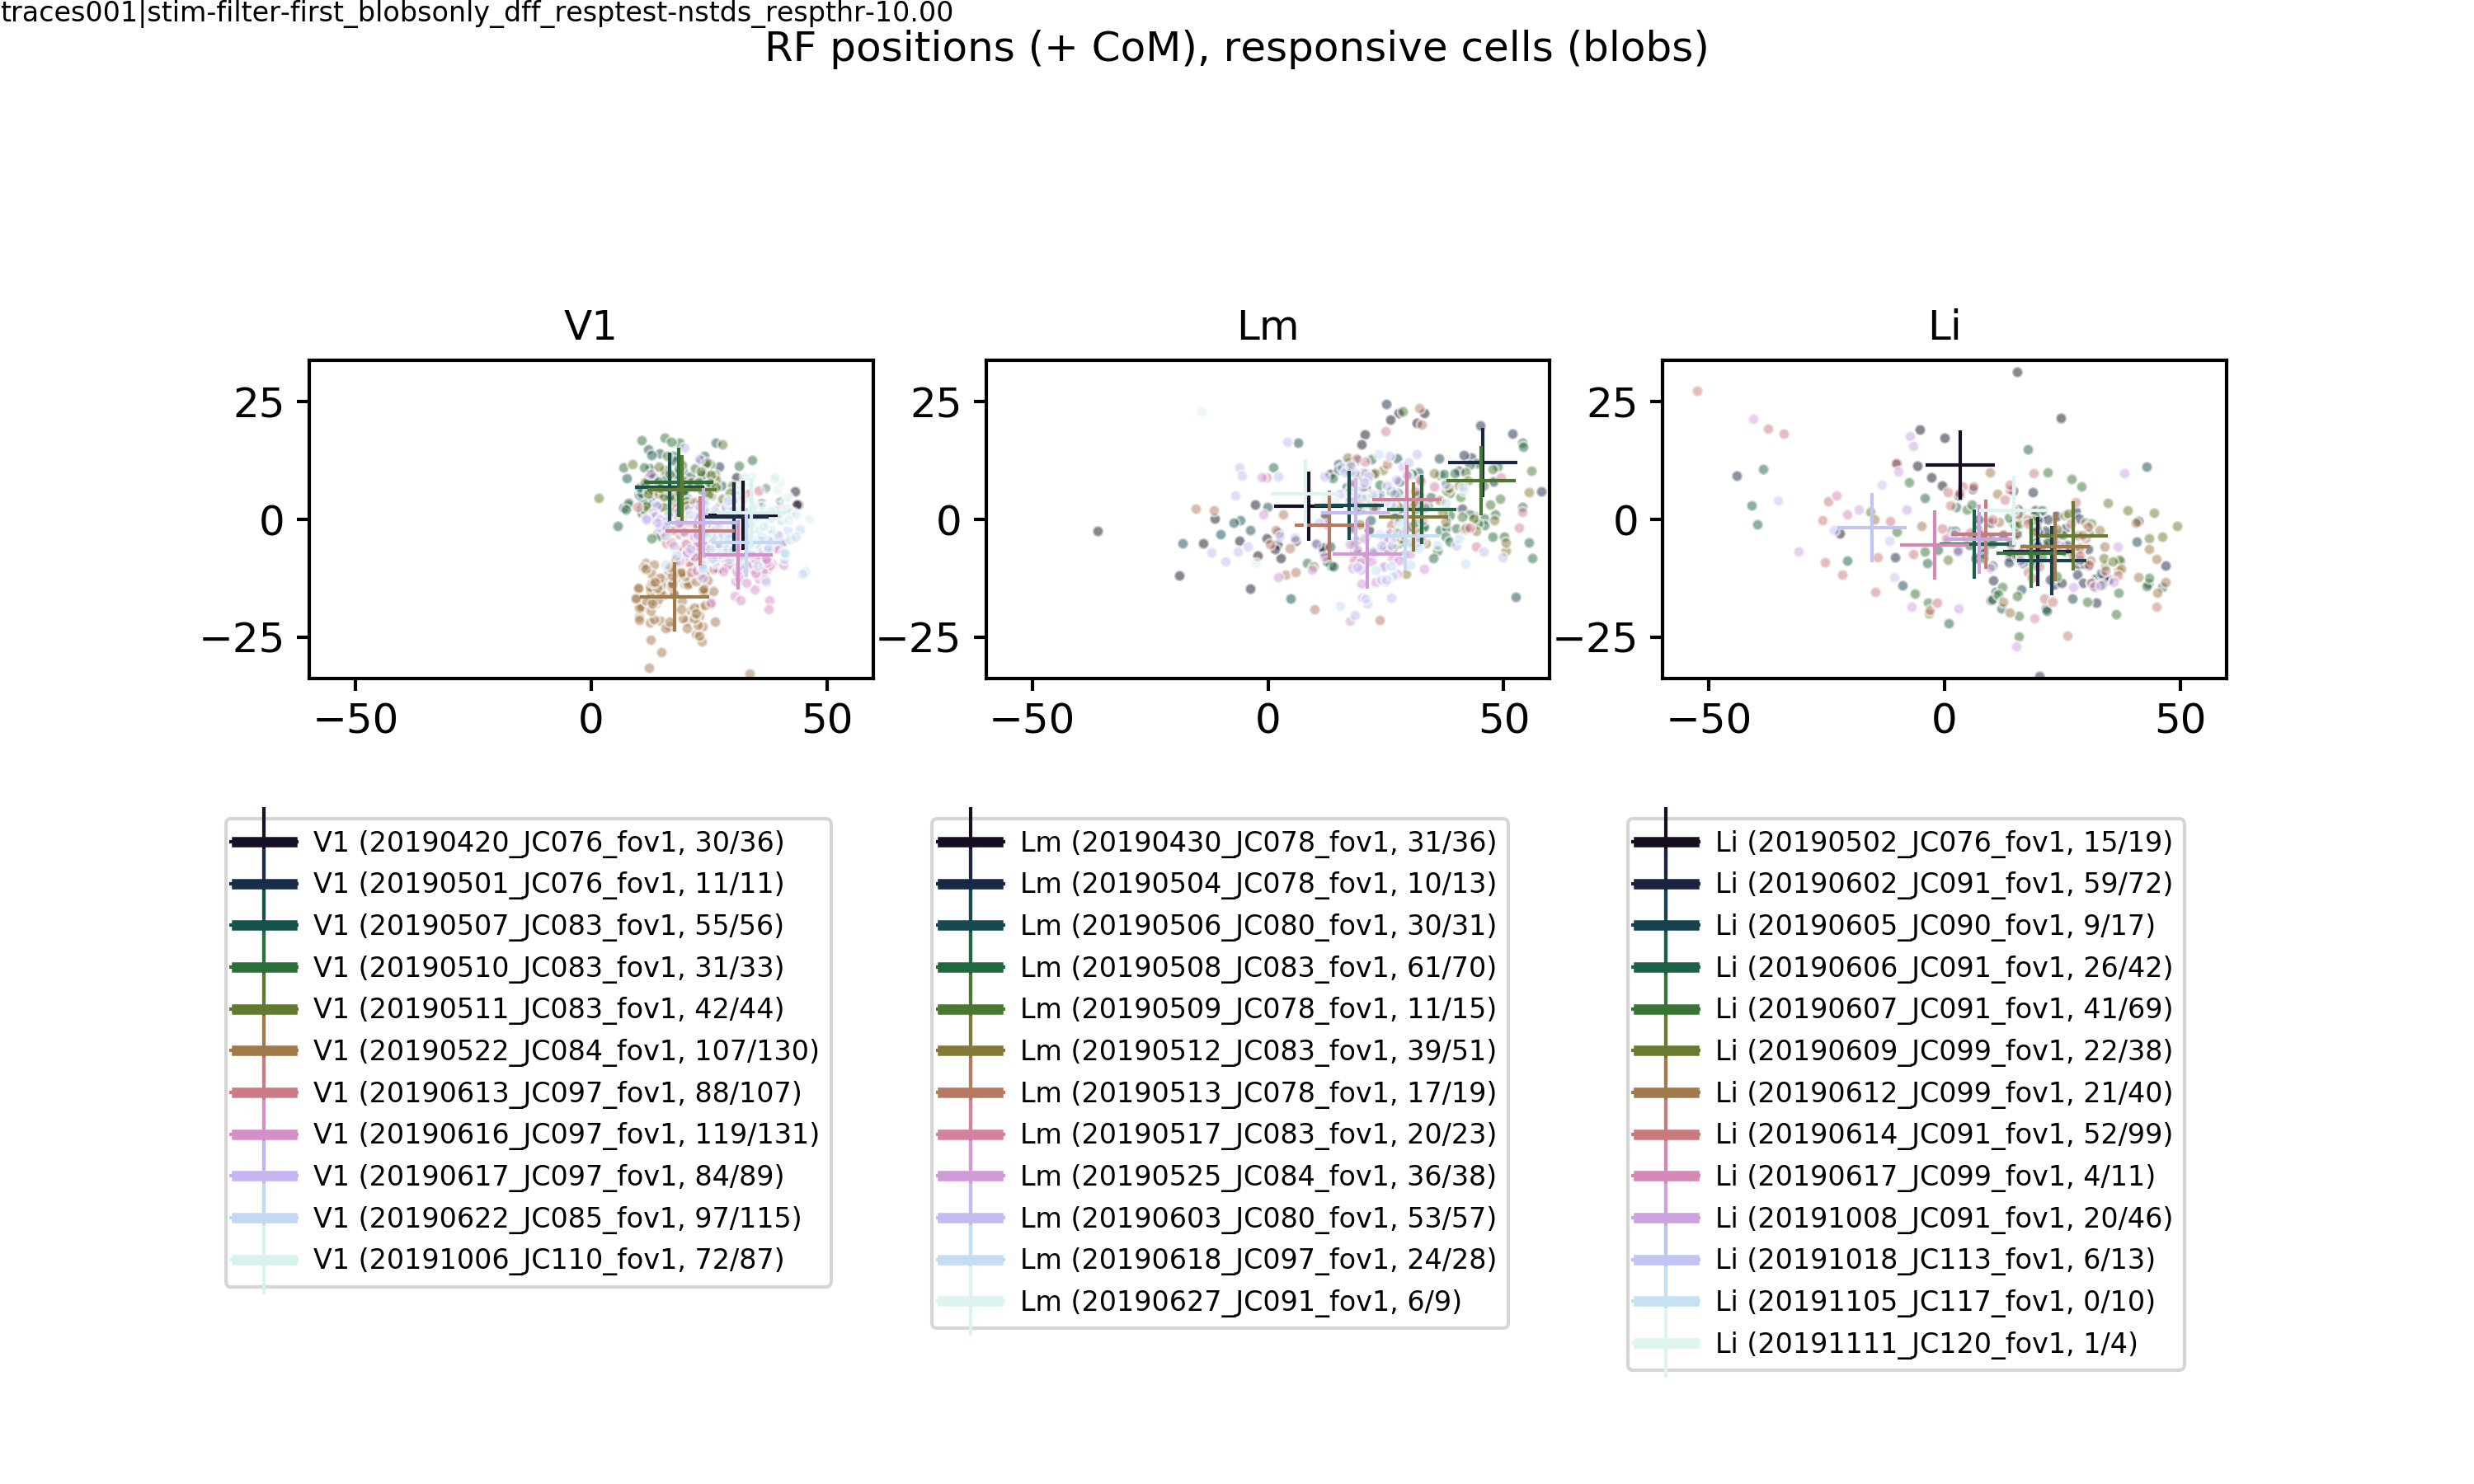

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff', 'CoM_label-fovs_common_to_blobs_and_rfs')


In [16]:
# Plot
fig = dutils.plot_all_rfs(RFs, MEANS, screeninfo, cmap='cubehelix')
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % experiment)
putils.label_figure(fig, data_id)
figname = 'CoM_label-fovs_common_to_blobs_and_rfs'
pl.savefig(os.path.join(aggr_rf_dir, '%s.svg' % figname))
print(aggr_rf_dir, figname)

# Calculate overlap with stimulus

#### Test with example FOV

In [19]:
experiment = 'blobs'

# TEST
animalid = 'JC110'
session = '20191006'
fovnum = 1

datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

20191006_JC110_fov1
Stimuli presented at coords: (30, 0)


In [36]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

g = RFs[RFs['datakey']==datakey].copy()

# Convert RF fit params to polygon
g.index = g['cell'].values
rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
# Concatenate into dataframe
perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})

In [36]:
perc_overlap

,area_overlap,stim_size,perc_overlap,cell
0,100.000000,10,1.000000,4.0
0,100.000000,10,1.000000,5.0
0,100.000000,10,1.000000,6.0
0,100.000000,10,1.000000,11.0
0,100.000000,10,1.000000,12.0
0,100.000000,10,1.000000,18.0
0,100.000000,10,1.000000,19.0
0,100.000000,10,1.000000,23.0
0,100.000000,10,1.000000,27.0
0,100.000000,10,1.000000,29.0


<IPython.core.display.Javascript object>


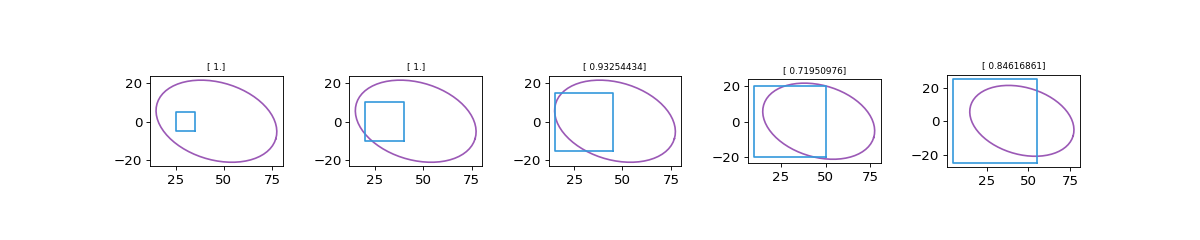

(0, array([ 1.]))
(1, array([ 1.]))
(2, array([ 0.93254434]))
(3, array([ 0.71950976]))
(4, array([ 0.84616861]))


In [69]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    #perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (stim_ix, p_stim))
    perc_overlap = rfutils.get_proportion_overlap(rf_poly, p_stim) 
    
    #print(perc_overlap)rfutils.get_proportion_overlap(rf_poly, stim_poly)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    ax.set_title(perc_overlap['perc_overlap'].values, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim[1].exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
    
pl.subplots_adjust(wspace=0.5)

In [67]:
perc_overlap

,area_overlap,col,perc_overlap,row
0,1273.943458,50,0.846169,384.0


# For all RFs measured, calculate overlap with stimuli

In [17]:
#### Calculate overlap with stimulus
stim_overlaps = dutils.calculate_overlaps(RFs, MEANS.keys(), experiment=experiment)


Stimuli presented at coords: (-5, 8)
Stimuli presented at coords: (15, 0)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -8)
Stimuli presented at coords: (20, -5)
Stimuli presented at coords: (10, -5)
---> (warning): no anatomicals for (JC091|20191008|FOV1_zoom2p0x)
Stimuli presented at coords: (20, -10)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (25, -5)
Stimuli presented at coords: (-15, 0)
Stimuli presented at coords: (0, 5)
Stimuli presented at coords: (30, -5)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190509|FOV1_zoom2p0x)
Stimuli presented at coords: (30, 8)
---> (warning): no anatomicals for (JC078|20190513|FOV1_zoom2p0x)
Stimuli presented at coords: (20, 0)
Stimuli presented at coords: (15, 8)
Stimuli presented at coords: (15, 8)
---> (warning): no anatomicals for (JC083|20190508|FOV1_zoom2p0x)
Stimuli presented at co

<IPython.core.display.Javascript object>


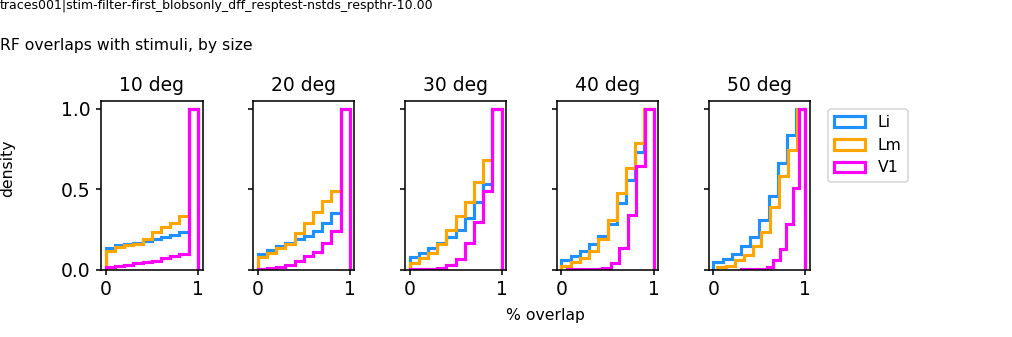

Text(0,0.85,u'RF overlaps with stimuli, by size')

In [22]:
# sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
#            kind='kdeplot', palette=area_colors, order=visual_areas)

fig, axn = pl.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True, dpi=dpi)
for ax, (sz, sg) in zip(axn.flat, stim_overlaps[['perc_overlap', 'visual_area', 'stim_size']].groupby(['stim_size'])):
    for v, vg in sg.groupby(['visual_area']):
        
        ax.hist(vg['perc_overlap'].values, color=area_colors[v], label=v,
                facecolor='none', edgecolor=area_colors[v], lw=2, alpha=1,
                density=True, cumulative=True, histtype='step')
    ax.set_title('%i deg' % (sz))
fig.text(0.5, 0.05, '% overlap')
fig.text(0.0, 0.5, 'density', rotation=90, va='center')

ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(wspace=0.5, top=0.7, right=0.8, bottom=0.2, left=0.1)

putils.label_figure(fig, data_id)
fig.text(0., 0.85, 'RF overlaps with stimuli, by size')

<IPython.core.display.Javascript object>


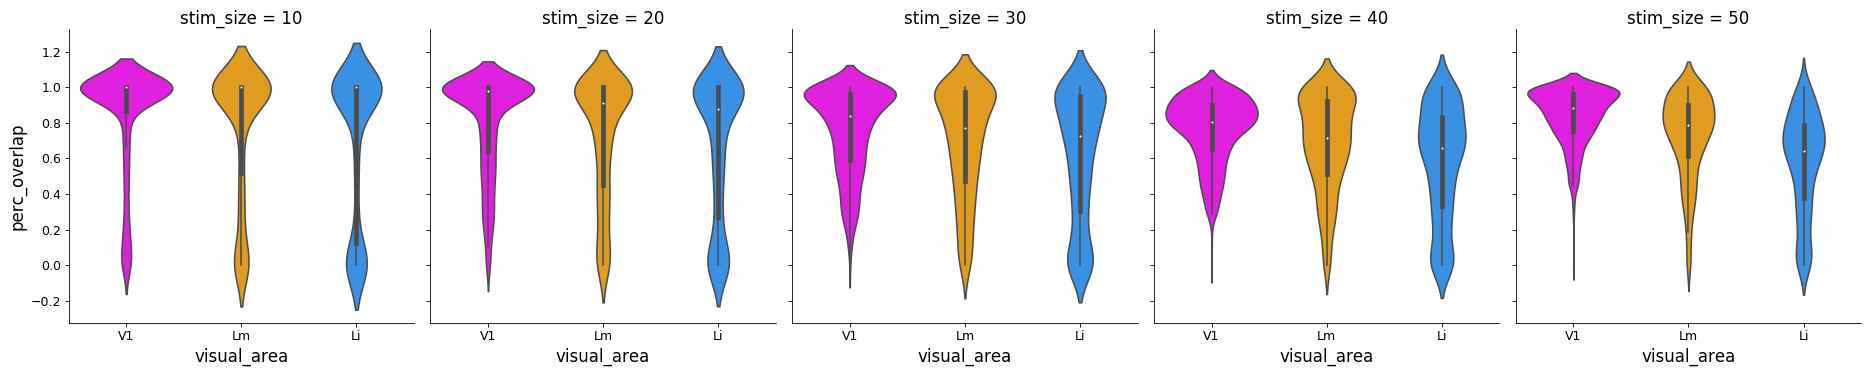

In [39]:
sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
           kind='violin', palette=area_colors, order=visual_areas)

# Get data common to RFs + blobs

In [18]:
# Get data common to RFs + blobs
c_list=[]
d_list = []
i=0
for (visual_area, datakey, rfname), g in stim_overlaps.groupby(['visual_area', 'datakey', 'rfname']):
    if datakey not in MEANS.keys():
        print("no %s: %s" % (experiment, datakey))
        continue

    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    rf_rids = sorted(g['cell'].unique())
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, (%s) %i common cells" % (visual_area, datakey, rfname, len(common_rids)))
    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i])) 
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    i+=1    
rfs_and_blobs = pd.concat(d_list, axis=0)   
common_counts = pd.concat(c_list, axis=0)

[Li] 20190502_JC076_fov1, (rfs) 15 common cells
[Li] 20190602_JC091_fov1, (rfs10) 59 common cells
[Li] 20190605_JC090_fov1, (rfs10) 9 common cells
[Li] 20190606_JC091_fov1, (rfs10) 26 common cells
[Li] 20190607_JC091_fov1, (rfs10) 41 common cells
[Li] 20190609_JC099_fov1, (rfs10) 22 common cells
[Li] 20190612_JC099_fov1, (rfs10) 21 common cells
[Li] 20190614_JC091_fov1, (rfs10) 52 common cells
[Li] 20190617_JC099_fov1, (rfs10) 4 common cells
[Li] 20191008_JC091_fov1, (rfs10) 20 common cells
[Li] 20191018_JC113_fov1, (rfs10) 6 common cells
[Li] 20191105_JC117_fov1, (rfs10) 0 common cells
[Li] 20191111_JC120_fov1, (rfs10) 1 common cells
[Lm] 20190430_JC078_fov1, (rfs) 31 common cells
[Lm] 20190504_JC078_fov1, (rfs) 10 common cells
[Lm] 20190506_JC080_fov1, (rfs) 30 common cells
[Lm] 20190508_JC083_fov1, (rfs) 61 common cells
[Lm] 20190509_JC078_fov1, (rfs) 11 common cells
[Lm] 20190512_JC083_fov1, (rfs) 39 common cells
[Lm] 20190513_JC078_fov1, (rfs) 17 common cells
[Lm] 20190517_JC083_f

In [19]:
common_counts.groupby(['visual_area']).count()

,datakey,n_cells,rfname
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


In [20]:
overlap_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

for overlap_thr in overlap_thr_values:
    pdf = rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].copy()
    print("----- Thr: %.2f --------------" % overlap_thr)
    print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

----- Thr: 0.00 --------------
             datakey  cell
visual_area               
Li               276   276
Lm               338   338
V1               736   736
----- Thr: 0.20 --------------
             datakey  cell
visual_area               
Li               264   264
Lm               337   337
V1               736   736
----- Thr: 0.40 --------------
             datakey  cell
visual_area               
Li               254   254
Lm               322   322
V1               736   736
----- Thr: 0.60 --------------
             datakey  cell
visual_area               
Li               248   248
Lm               302   302
V1               736   736
----- Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               241   241
Lm               272   272
V1               734   734
----- Thr: 1.00 --------------
             datakey  cell
visual_area               
Li               217   217
Lm               210   210
V1               664   664


# Set output dir

In [56]:
dst_dir = os.path.join(decoding_dir, 'train-subset')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-subset


# Linear separability, by RF overlap

In [22]:
import scipy.stats as spstats
import sklearn.metrics as skmetrics
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
# from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm


In [23]:
import multiprocessing as mp
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    pool.join()

def initializer(terminating_):
    # This places terminating in the global namespace of the worker subprocesses.
    # This allows the worker function to access `terminating` even though it is
    # not passed as an argument to the function.
    global terminating
    terminating = terminating_


def pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, n_iterations=50, n_processes=1,
                   test=None, single=False, n_train_configs=4):   
    '''
    test (string, None)
        None  : Classify A/B only (single=True to train/test on each size)
        morph : Train on anchors, test on intermediate morphs (single=True to train/test on each size)
        size  : Train on specific size(s), test on un-trained sizes (single=True to train/test on each size)
    '''
    
    results = []
    terminating = mp.Event()

    pool = mp.Pool(initializer=initializer, initargs=(terminating, ), processes=n_processes)  
    try:
        print("... n: %i (%i procs)" % (sample_ncells, n_processes))
        if test=='morph':
            if single: # train on 1 size, test on other sizes
                func = partial(dutils.do_fit_train_single_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else: # combine data across sizes
                func = partial(dutils.do_fit_train_test_morph, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)             
        elif test=='size':
            if single:
                func = partial(dutils.do_fit_train_test_single, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
            else:
                func = partial(dutils.cycle_train_sets, global_rois=global_rois, 
                               MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells, n_train_configs=n_train_configs)
        else:
            func = partial(dutils.do_fit, global_rois=global_rois, MEANS=MEANS, 
                           sdf=sdf, sample_ncells=sample_ncells)
        results = pool.map_async(func, range(n_iterations)).get(99999999)
        pool.close()
        pool.join()
    except KeyboardInterrupt:
        print("**interupt")
        pool.terminate()
        print("***Terminating!")
    finally:
        pool.close()
        pool.join()

    return results

In [24]:

# def do_fit_train_single_test_morph_FOV(iter_num, curr_data, sdf=None,
#                                cv=True, C_value=None, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106):
#     '''
#     Resample w/ replacement from pooled cells (across datasets). Assumes 'sdf' is same for all datasets.
#     Return fit results for 1 iteration.
#     Classes (class_a, class_b) should be the actual labels of the target (i.e., value of morph level)
#     '''
#     # Get new sample set
#     #curr_data = dutils.get_trials_for_N_cells(sample_ncells, global_rois, MEANS)

#     #### Select train/test configs for clf A vs B
#     class_types = [class_a, class_b]
#     restrict_transform = True
#     class_name='morphlevel'
#     constant_transform = 'size'
#     sizes = sorted(sdf[constant_transform].unique())
    
#     i_list=[]
#     i=0
#     # Go thru all training sizes, then test on non-trained sizes
#     for train_transform in sizes:

#         # Get train configs -- ANCHORS (A/B)
#         train_configs = sdf[(sdf[class_name].isin(class_types))
#                            & (sdf[constant_transform]==train_transform)].index.tolist()

#         #### TRAIN SET --------------------------------------------------------------------
#         # Get trial data for selected cells and config types
#         curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
#         trainset = curr_data[curr_data['config'].isin(train_configs)].copy()
#         train_data = trainset.drop('config', 1)#zdata = (data - data.mean()) / data.std()

#         # Get labels
#         targets = pd.DataFrame(trainset['config'].copy(), columns=['config'])
#         targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
#         targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

#         #### TEST SET --------------------------------------------------------------------
#         # Get data, specify configs
#         novel_class_types = [c for c in sdf[class_name].unique() if c not in class_types]
#         test_configs = sdf[(sdf[class_name].isin(novel_class_types))
#                           & (sdf[constant_transform]==train_transform)].index.tolist()
        
#         testset = curr_data[curr_data['config'].isin(test_configs)]
#         test_data = testset.drop('config', 1) #zdata = (data - data.mean()) / data.std()

#         # Get labels.
#         test_targets = pd.DataFrame(testset['config'].copy(), columns=['config'])
#         test_targets['label'] = [sdf['morphlevel'][cfg] for cfg in test_targets['config'].values]
#         test_targets['group'] = [sdf['size'][cfg] for cfg in test_targets['config'].values]

#         #### Train SVM ----------------------------------------------------------------------
#         iterdict, trained_svc, trained_scaler, (predicted_labels, true_labels) = dutils.fit_svm(train_data, targets, 
#                                                             return_clf=True, return_predictions=True,
#                                                             test_split=test_size, cv_nfolds=cv_nfolds, 
#                                                             cv=cv, C_value=C_value)
#         for anchor in [class_a, class_b]:
#             a_ixs = np.array([i for i, v in enumerate(true_labels) if v==anchor])
#             p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels[a_ixs]])/float(len(predicted_labels[a_ixs]))
#             iterdict.update({'p_chooseB': p_chooseB, 
#                              '%s' % class_name: anchor, 
#                              '%s' % constant_transform: train_transform})
#             i_list.append(pd.DataFrame(iterdict, index=[i]))
#             i+=1

#         #### Test SVM
#         for test_transform, curr_test_group in test_targets.groupby(['label']):
#             curr_test_data = test_data.loc[curr_test_group.index].copy()
#             curr_test_data = trained_scaler.transform(curr_test_data)

#             #### Calculate p choose B on trials where morph X shown (test_transform)
#             predicted_labels = trained_svc.predict(curr_test_data)
#             p_chooseB = sum([1 if p==class_b else 0 for p in predicted_labels])/float(len(predicted_labels))

#             iterdict.update({'p_chooseB': p_chooseB, 
#                              '%s' % class_name: test_transform,
#                              '%s' % constant_transform: train_transform})
            
#             i_list.append(pd.DataFrame(iterdict, index=[i]))
#             i+=1 
            
#     iterdf = pd.concat(i_list, axis=0).reset_index(drop=True)
#     iterdf['iteration'] = [iter_num for _ in np.arange(0, len(iterdf))]
    
#     return iterdf

# Set decoding params

In [31]:
test_size=0.2
cv_nfolds=5
cv=True

class_a=0
class_b=106
class_name='morphlevel'
constant_transform='size'

# Pool cells

In [33]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [29]:
not_in_means = [r for r in MEANS.keys() if r not in stim_datakeys] # all blobs
not_in_rfs = [r for r in rfs_and_blobs['datakey'].unique() if r not in stim_datakeys] # all blobs w/ RFs (kinda)
print(len(not_in_rfs), len(not_in_means))

(11, 12)


In [35]:
overlap_thr=0.8
filter_fovs = True
remove_too_few = False
min_ncells = 20 if remove_too_few else 0

# ------------------------------------------------------------------------------------
filter_str = 'filter-repeat-fovs' if filter_fovs else 'all-fovs'
filter_str = '%s_%s' % (filter_str, 'remove-few') if remove_too_few else filter_str
print(filter_str)

pooled_cells, cell_counts = dutils.get_pooled_cells(stim_datakeys, rfs_and_blobs, 
                                                     filter_fovs=filter_fovs, 
                                                     remove_too_few=remove_too_few, 
                                                     overlap_thr=overlap_thr, 
                                                     min_ncells=min_ncells)

# Make sure have SAME N trials total
keys_with_min_reps = [k for k in stim_datakeys 
                      if MEANS[k]['config'].value_counts().min() < 29]
filt_globaldf = pooled_cells[~pooled_cells['datakey'].isin(keys_with_min_reps)]
print(filt_globaldf[~filt_globaldf['datakey'].isin(keys_with_min_reps)]['visual_area'].value_counts())

print("--- final totals ---")
print(cell_counts)

sample_ncells = min(cell_counts.values())
print("Selecting %i cells for sample size" % sample_ncells)

filter-repeat-fovs
('V1', 650)
('Lm', 201)
('Li', 127)
V1    650
Lm    201
Li    112
Name: visual_area, dtype: int64
--- final totals ---
{'V1': 650, 'Lm': 201, 'Li': 127}
Selecting 127 cells for sample size


In [45]:
overlap_thr

0.8

In [41]:
rootdir='/n/coxfs01/2p-data'
animalid='JC097'
session = '20190616'
fov='FOV1_zoom2p0x'
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

In [47]:
n_iterations = 100
n_train_configs = 4
n_processes=1

    
r_list=[]
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

    iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                               test='size', single=False, n_train_configs=4,
                               n_iterations=n_iterations, n_processes=n_processes)
    iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)
    
    add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
    iterdf = putils.add_meta_to_df(iterdf, add_info)

    r_list.append(iterdf)

results = pd.concat(r_list, axis=0).reset_index(drop=True)
print(r_list[0].shape, results.shape)


... n: 127 (1 procs)
... n: 127 (1 procs)
... n: 127 (1 procs)
((1000, 19), (3000, 19))


In [59]:
outfile = os.path.join(dst_dir, 'results_nsample-%i_iter-%i.pkl' % (sample_ncells, n_iterations))

print(outfile)

with open(outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-subset/results_nsample-127_iter-100.pkl


In [54]:
results.groupby(['train_transform', 'test_transform']).mean()

C  fit_time  heldout_MI  \
train_transform     test_transform                                       
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0  0.07237  0.003163    0.120912   
                    50.0                 0.07237  0.003163    0.194905   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0  0.08908  0.003184    0.113917   
                    40.0                 0.08908  0.003184    0.221476   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0  0.06301  0.003133    0.126620   
                    30.0                 0.06301  0.003133    0.187901   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0  0.06373  0.002948    0.148484   
                    20.0                 0.06373  0.002948    0.091079   
20.0_30.0_40.0_50.0 10.0                 0.05881  0.002834    0.020424   
                    20.0_30.0_40.0_50.0  0.05881  0.002834    0.214930   

                                         heldout_aMI  heldout_log2MI  \
train_transform     test_transform                                     
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0     0.162020        0.174439   
                    50.0                    0.271893        0.281189   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0     0.151579        0.164348   
                    40.0                    0.310704        0.319522   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0     0.170401        0.182674   
                    30.0                    0.261639        0.271083   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0     0.202512        0.214217   
                    20.0                    0.120145        0.131399   
20.0_30.0_40.0_50.0 10.0                    0.016843        0.029465   
                    20.0_30.0_40.0_50.0     0.300602        0.310078   

                                         heldout_test_score  score_time  \
train_transform     test_transform                                        
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0            0.720567    0.002587   
                    50.0                           0.773103    0.002587   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0            0.715957    0.002566   
                    40.0                           0.800287    0.002566   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0            0.729504    0.002602   
                    30.0                           0.777874    0.002602   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0            0.747163    0.002531   
                    20.0                           0.695057    0.002531   
20.0_30.0_40.0_50.0 10.0                           0.556552    0.002413   
                    20.0_30.0_40.0_50.0            0.801348    0.002413   

                                         test_accuracy  test_precision_macro  \
train_transform     test_transform                                             
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0       0.718394              0.724316   
                    50.0                      0.718394              0.724316   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0       0.719352              0.727471   
                    40.0                      0.719352              0.727471   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0       0.727254              0.735561   
                    30.0                      0.727254              0.735561   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0       0.750118              0.758010   
                    20.0                      0.750118              0.758010   
20.0_30.0_40.0_50.0 10.0                      0.797474              0.803876   
                    20.0_30.0_40.0_50.0       0.797474              0.803876   

                                         test_recall_macro  train_accuracy  \
train_transform     test_transform                                           
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0           0.717621        0.910946   
                    50.0                          0.717621        0.910946   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0           0.718956        0.903668   
                    40.0                 

In [65]:
results.groupby(['visual_area', 'train_transform', 'test_transform']).mean()[['heldout_test_score', 'heldout_MI']]

heldout_test_score  \
visual_area train_transform     test_transform                            
Li          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0            0.740851   
                                50.0                           0.750862   
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0            0.715745   
                                40.0                           0.785345   
            10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0            0.731702   
                                30.0                           0.807414   
            10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0            0.746596   
                                20.0                           0.705517   
            20.0_30.0_40.0_50.0 10.0                           0.622759   
                                20.0_30.0_40.0_50.0            0.790851   
Lm          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0            0.668511   
                                50.0                           0.724828   
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0            0.672766   
                                40.0                           0.747759   
            10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0            0.685745   
                                30.0                           0.714655   
            10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0            0.701702   
                                20.0                           0.658276   
            20.0_30.0_40.0_50.0 10.0                           0.521207   
                                20.0_30.0_40.0_50.0            0.757234   
V1          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0            0.752340   
                                50.0                           0.843621   
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0            0.759362   
                                40.0                           0.867759   
            10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0            0.771064   
                                30.0                           0.811552   
            10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0            0.793191   
                                20.0                           0.721379   
            20.0_30.0_40.0_50.0 10.0                           0.525690   
                                20.0_30.0_40.0_50.0            0.855957   

                                                     heldout_MI  
visual_area train_transform     test_transform                   
Li          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0    0.138478  
                                50.0                   0.176716  
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0    0.108741  
                                40.0                   0.200070  
            10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0    0.123312  
                                30.0                   0.223784  
            10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0    0.141115  
                                20.0                   0.094669  
            20.0_30.0_40.0_50.0 10.0                   0.041333  
                                20.0_30.0_40.0_50.0    0.191111  
Lm          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0    0.073193  
                                50.0                   0.126355  
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0    0.077796  
                                40.0                   0.140227  
            10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0    0.084912  
                                30.0                   0.111660  
            10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0    0.101942  
                                20.0                   0.060332  
            20.0_30.0_40.0_50.0 10.0                   0.010325  
                                20.0_30.0_40.0_50.0    0.152274  
V1          10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0    0.151064  
                                50.0                   0.281645  
            10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0    0.155214  
  

In [69]:
results.groupby(['train_transform', 'test_transform']).mean()

C  fit_time  heldout_MI  \
train_transform     test_transform                                       
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0  0.07237  0.003163    0.120912   
                    50.0                 0.07237  0.003163    0.194905   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0  0.08908  0.003184    0.113917   
                    40.0                 0.08908  0.003184    0.221476   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0  0.06301  0.003133    0.126620   
                    30.0                 0.06301  0.003133    0.187901   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0  0.06373  0.002948    0.148484   
                    20.0                 0.06373  0.002948    0.091079   
20.0_30.0_40.0_50.0 10.0                 0.05881  0.002834    0.020424   
                    20.0_30.0_40.0_50.0  0.05881  0.002834    0.214930   

                                         heldout_aMI  heldout_log2MI  \
train_transform     test_transform                                     
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0     0.162020        0.174439   
                    50.0                    0.271893        0.281189   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0     0.151579        0.164348   
                    40.0                    0.310704        0.319522   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0     0.170401        0.182674   
                    30.0                    0.261639        0.271083   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0     0.202512        0.214217   
                    20.0                    0.120145        0.131399   
20.0_30.0_40.0_50.0 10.0                    0.016843        0.029465   
                    20.0_30.0_40.0_50.0     0.300602        0.310078   

                                         heldout_test_score  score_time  \
train_transform     test_transform                                        
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0            0.720567    0.002587   
                    50.0                           0.773103    0.002587   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0            0.715957    0.002566   
                    40.0                           0.800287    0.002566   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0            0.729504    0.002602   
                    30.0                           0.777874    0.002602   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0            0.747163    0.002531   
                    20.0                           0.695057    0.002531   
20.0_30.0_40.0_50.0 10.0                           0.556552    0.002413   
                    20.0_30.0_40.0_50.0            0.801348    0.002413   

                                         test_accuracy  test_precision_macro  \
train_transform     test_transform                                             
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0       0.718394              0.724316   
                    50.0                      0.718394              0.724316   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0       0.719352              0.727471   
                    40.0                      0.719352              0.727471   
10.0_20.0_40.0_50.0 10.0_20.0_40.0_50.0       0.727254              0.735561   
                    30.0                      0.727254              0.735561   
10.0_30.0_40.0_50.0 10.0_30.0_40.0_50.0       0.750118              0.758010   
                    20.0                      0.750118              0.758010   
20.0_30.0_40.0_50.0 10.0                      0.797474              0.803876   
                    20.0_30.0_40.0_50.0       0.797474              0.803876   

                                         test_recall_macro  train_accuracy  \
train_transform     test_transform                                           
10.0_20.0_30.0_40.0 10.0_20.0_30.0_40.0           0.717621        0.910946   
                    50.0                          0.717621        0.910946   
10.0_20.0_30.0_50.0 10.0_20.0_30.0_50.0           0.718956        0.903668   
                    40.0                 

In [81]:
vdf.groupby(['test_transform']).mean().reset_index()

,test_transform,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro,iteration,n_units,overlap
0,10.0,0.02476,0.002628,0.009614,0.001039,0.013870,0.525690,0.002356,0.851551,0.857075,0.851073,0.966568,0.967165,0.966413,49.5,127.0,0.8
1,20.0_30.0_40.0_50.0,0.02476,0.002628,0.301404,0.427876,0.434834,0.855957,0.002356,0.851551,0.857075,0.851073,0.966568,0.967165,0.966413,49.5,127.0,0.8


In [91]:
for (visual_area, train_transform), vdf in results.groupby(['visual_area', 'train_transform']):
    train_vals = vdf[vdf['test_transform']==train_transform].mean()
    test_vals = vdf[vdf['test_transform']!=train_transform].mean()
    print("%s: %.2f (train), %.2f (test) [%s]" % (visual_area, 
                                                  train_vals[metric], 
                                                  test_vals[metric], train_transform))


Li: 0.74 (train), 0.75 (test) [10.0_20.0_30.0_40.0]
Li: 0.72 (train), 0.79 (test) [10.0_20.0_30.0_50.0]
Li: 0.73 (train), 0.81 (test) [10.0_20.0_40.0_50.0]
Li: 0.75 (train), 0.71 (test) [10.0_30.0_40.0_50.0]
Li: 0.79 (train), 0.62 (test) [20.0_30.0_40.0_50.0]
Lm: 0.67 (train), 0.72 (test) [10.0_20.0_30.0_40.0]
Lm: 0.67 (train), 0.75 (test) [10.0_20.0_30.0_50.0]
Lm: 0.69 (train), 0.71 (test) [10.0_20.0_40.0_50.0]
Lm: 0.70 (train), 0.66 (test) [10.0_30.0_40.0_50.0]
Lm: 0.76 (train), 0.52 (test) [20.0_30.0_40.0_50.0]
V1: 0.75 (train), 0.84 (test) [10.0_20.0_30.0_40.0]
V1: 0.76 (train), 0.87 (test) [10.0_20.0_30.0_50.0]
V1: 0.77 (train), 0.81 (test) [10.0_20.0_40.0_50.0]
V1: 0.79 (train), 0.72 (test) [10.0_30.0_40.0_50.0]
V1: 0.86 (train), 0.53 (test) [20.0_30.0_40.0_50.0]


V1: 0.86 (train), 0.53 (test) [20.0_30.0_40.0_50.0]


In [87]:
train_vals[metric], test_vals[metric]

(0.8559574468085107, 0.5256896551724137)

In [68]:
# Plot.
metric = 'heldout_test_score'
fig, axn = pl.subplots(1, 3, dpi=dpi, figsize=(12,4), sharex=True, sharey=True)

for visual_area, vdf in results.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)

    mean_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).mean()[metric]
    sem_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).sem()[metric]


    #currdf = traindf.groupby(['test_transform']).mean().reset_index()
    #currdf_sem = traindf.groupby(['test_transform']).sem().reset_index()

    xv = sorted(currdf['test_transform'].values)
    yv = currdf.sort_values(by='test_transform')['%s' % metric].values
    yv_err = currdf_sem.sort_values(by='test_transform')['%s' % metric].values

    #train_index = xv.index(train_transform)

    ax.errorbar(xv, yv, yerr=yv_err, color=area_colors[visual_area])
#         ax.errorbar(xv[train_index], yv[train_index], yerr=yv_err[train_index], color=area_colors[visual_area],
#                    marker='o', markersize=10)

    ax.set_title(train_transform)
    ax.axhline(y=0.5, color='k', linestyle=':')
    #ax.set_ylim([0.4, 1])
    ax.set_xticks(sizes)
    ax.set_xticklabels([int(s) for s in sizes])
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

<IPython.core.display.Javascript object>

NameError: name 'traindf' is not defined

In [36]:
dst_dir = os.path.join(decoding_dir, 'train-anchors')

<IPython.core.display.Javascript object>


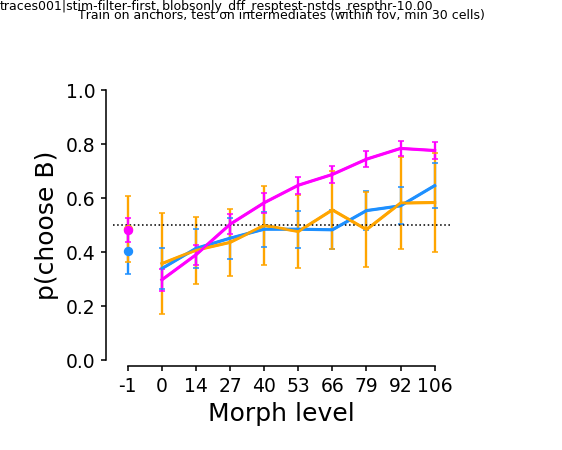

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors_by-FOV_min-30-cells_wLum')


In [46]:
ci=95
markersize=5
lw=2
capsize=2
plot_luminance=True
plot_ci=False
#shade=False
plot_str = 'wLum' if plot_luminance else ''
plot_str = '%s_ci%i' % (plot_str, ci) if plot_ci else plot_str

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))
ax = plot_morph_curves(xdf, sdf, col_name='morphlevel', ci=ci, plot_luminance=plot_luminance, 
                      lw=lw, capsize=capsize, markersize=markersize, plot_ci=plot_ci,
                       area_colors=area_colors, ax=ax, dpi=dpi)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8)
ax.axhline(y=0.5, linestyle=':', color='k', lw=1)

sns.despine(trim=True, offset=4)
pl.suptitle("Train on anchors, test on intermediates (within fov, min %i cells)" % (min_ncells), fontsize=8)

putils.label_figure(fig, data_id)

figname = 'train-anchors_by-FOV_min-%i-cells_%s' % (min_ncells, plot_str)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [407]:
xdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    10
Lm     7
Li     5
Name: visual_area, dtype: int64

#### Test space

In [120]:
iter_num=0
sample_ncells=200
global_rois = filt_globaldf[filt_globaldf['visual_area']=='V1']
iterdf = do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                 sample_ncells=sample_ncells,
                                 cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)


In [123]:
iterdf.groupby(['size', 'morphlevel']).mean()['p_chooseB']

size  morphlevel
10.0  -1            0.206897
       0            0.600000
       14           0.379310
       27           0.517241
       40           0.620690
       53           0.517241
       66           0.517241
       79           0.586207
       92           0.482759
       106          0.857143
20.0  -1            0.965517
       0            0.125000
       14           0.379310
       27           0.620690
       40           0.586207
       53           0.793103
       66           0.793103
       79           0.758621
       92           0.862069
       106          0.750000
30.0  -1            0.586207
       0            0.375000
       14           0.379310
       27           0.586207
       40           0.724138
       53           0.724138
       66           0.655172
       79           0.758621
       92           0.862069
       106          0.750000
40.0  -1            0.517241
       0            0.166667
       14           0.379310
       27           0.5517

# RFECV

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [52]:
n_iterations = 100
d_list = []
for n in np.arange(0, n_iterations):
    if n%20==0:
        print("...%i of %i" % (n, n_iterations))
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):
        total_ncells = min(cell_counts.values()) #cell_counts[visual_area]

        curr_data = dutils.get_trials_for_N_cells(total_ncells, global_rois, MEANS)
        train_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist()
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(train_configs)].copy()
        x = sample_data.drop('config', 1)
        zdata = StandardScaler().fit_transform(x)

        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])   
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]   
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        # Create the RFE object and compute a cross-validated score.
        svc = SVC(kernel="linear", C=0.0001)

        # The "accuracy" scoring is proportional to the number of correct
        # classifications
        rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(cv_nfolds, shuffle=True, random_state=10),
                      scoring='accuracy')
        rfecv.fit(zdata, targets['label'].values)

        d_list.append(pd.DataFrame({'score': rfecv.grid_scores_,
                                    'visual_area': [visual_area for _ in np.arange(0, total_ncells)],
                                    'iteration': [n for _ in np.arange(0, total_ncells)]}))
rfe_df = pd.concat(d_list, axis=0)


...0 of 100


KeyboardInterrupt: 

In [ ]:
fig, ax = pl.subplots()
for visual_area, df_ in rfe_df.groupby(['visual_area']):
    total_ncells = cell_counts[visual_area]
    
    mean_scores = df_.mean()['score']
    sem_scores = df_.sem()['scores']
    
    # Plot number of features VS. cross-validation scores
    ax.plot(range(1, len(rfecv.grid_scores_) + 1), mean_scores, color=area_colors[visual_area], 
           lw=lw, label=visual_area)
    ax.fill_between(xvs, mean_scores-sem_scores, mean_scores+sem_scores, alpha=0.5, color=area_colors[visual_area])
    

ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score\n(# of correct classifications)")


In [197]:
rfecv.grid_scores_

(112,)

# Train on anchors, test on morphs (combine all sizes)

In [69]:

def plot_morph_curves(results, sdf, col_name='test_transform', plot_ci=False, ci=95, plot_luminance=True, lw=2, 
                      capsize=3, markersize=5, area_colors=None, ax=None, dpi=150, alpha=1, label=None):
    
    if area_colors is None:
        visual_areas, area_colors = putils.set_threecolor_palette()

    if ax is None:
        fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

    morphlevels = sorted([s for s in sdf['morphlevel'].unique() if s!=-1])
    xvs = np.arange(1, len(morphlevels)+1) #if plot_luminance else np.arange(0, len(morphlevels))
    
    for visual_area, df_ in results.groupby(['visual_area']):
        
        if plot_luminance:
            # plot luminance control
            control_val=-1
            if plot_ci:
                ctl, ctl_lo, ctl_hi = dutils.calculate_ci(df_[df_[col_name]==control_val]['p_chooseB'].values, ci=ci)
                yerr = [abs(np.array([ctl-ctl_lo])), abs(np.array([ctl_hi-ctl]))]
            else:
                ctl = df_[df_[col_name]==control_val]['p_chooseB'].mean()
                yerr = df_[df_[col_name]==control_val]['p_chooseB'].sem()

            ax.errorbar(0, ctl, yerr=yerr, color=area_colors[visual_area],
                           marker='o', markersize=markersize, capsize=capsize, alpha=alpha)
            
        # plot morph curves
        if plot_ci:
            ci_vals = dict((val, dutils.calculate_ci(g['p_chooseB'].values, ci=ci)) \
                             for val, g in df_[df_[col_name].isin(morphlevels)].groupby([col_name]))
            mean_vals = np.array([ci_vals[k][0] for k in morphlevels])
            lowers = np.array([ci_vals[k][1] for k in morphlevels])
            uppers =  np.array([ci_vals[k][2] for k in morphlevels])
            yerr = [np.array([mean_vals - lowers]), np.array([mean_vals-uppers])]
        else:
            mean_vals = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).mean()['p_chooseB']
            yerr = df_[df_[col_name].isin(morphlevels)].groupby([col_name]).sem()['p_chooseB']

        ax.plot(xvs, mean_vals, color=area_colors[visual_area], lw=lw, alpha=alpha, label=label)
        ax.errorbar(xvs, mean_vals, yerr=yerr, color=area_colors[visual_area],
                          capsize=capsize, alpha=alpha, label=None)


        ax.set_ylim([0, 1])

    xticks = np.arange(0, len(morphlevels)+1) if plot_luminance else xvs
    xlabels = sdf['morphlevel'].unique() if plot_luminance else sdf[sdf['morphlevel']!=-1]['morphlevel'].unique()
    ax.set_xticks(xticks)
    ax.set_xticklabels( [int(m) for m in sorted(xlabels)] )
    ax.set_ylabel('p(choose B)')
    ax.set_xlabel('Morph level')
    
    return ax


In [59]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [66]:
sample_ncells=112

train_str = 'train-anchors-split-size_sample-%i_iter-%i' % (sample_ncells, n_iterations)
res_outfile = os.path.join(dst_dir, '%s_results.pkl' % train_str)
print(res_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results.pkl


In [61]:

r_list=[]
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

#     iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
#                                test_generalization=True, single=False, n_train_configs=4,
#                                n_iterations=n_iterations, n_processes=n_processes)
#     iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)
        
    iter_list=[]
    for iter_num in np.arange(0,  n_iterations):
        if iter_num%20==0:
            print("... (%s) %i of %i" % (visual_area, iter_num, n_iterations))   
        tmpdf = dutils.do_fit_train_single_test_morph(iter_num, global_rois=global_rois, MEANS=MEANS, sdf=sdf, 
                                     sample_ncells=sample_ncells,
                                     cv=True, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106)
        iter_list.append(tmpdf)
    iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

    add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
    iterdf = putils.add_meta_to_df(iterdf, add_info)

    r_list.append(iterdf)

results = pd.concat(r_list, axis=0).reset_index(drop=True)
print(r_list[0].shape, results.shape)



... (Li) 0 of 100
... (Li) 20 of 100
... (Li) 40 of 100
... (Li) 60 of 100
... (Li) 80 of 100
... (Lm) 0 of 100
... (Lm) 20 of 100
... (Lm) 40 of 100
... (Lm) 60 of 100
... (Lm) 80 of 100
... (V1) 0 of 100
... (V1) 20 of 100
... (V1) 40 of 100
... (V1) 60 of 100
... (V1) 80 of 100
((5000, 20), (15000, 20))


In [67]:
res_outfile = os.path.join(dst_dir, '%s_results2.pkl' % train_str)

# Save
print("Done!")
with open(res_outfile, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved to: %s" % res_outfile)


Done!
Saved to: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors/train-anchors-split-size_sample-112_iter-100_results2.pkl


In [68]:
results.groupby(['visual_area', 'size', 'morphlevel']).mean()['p_chooseB']

visual_area  size  morphlevel
Li           10.0  -1            0.719655
                    0            0.329552
                    14           0.350690
                    27           0.397241
                    40           0.433793
                    53           0.374828
                    66           0.436897
                    79           0.633103
                    92           0.697931
                    106          0.601048
             20.0  -1            0.214483
                    0            0.298083
                    14           0.323793
                    27           0.371379
                    40           0.413103
                    53           0.366897
                    66           0.466897
                    79           0.580690
                    92           0.651724
                    106          0.623306
             30.0  -1            0.227931
                    0            0.239770
                    14           0.227586
    

In [98]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [99]:
train_str

'train-anchors-split-size_sample-112_iter-100'

<IPython.core.display.Javascript object>


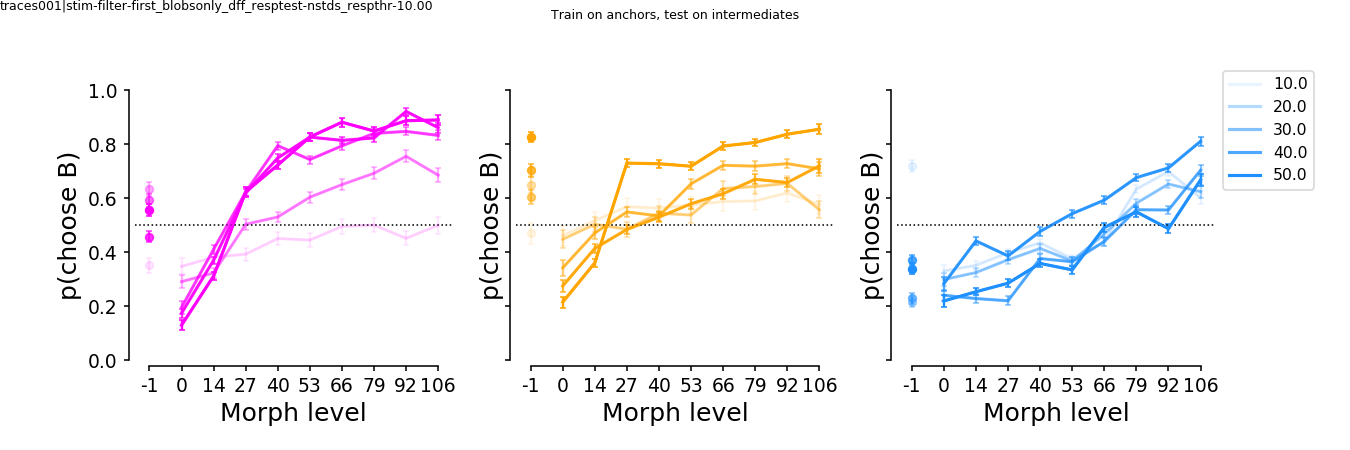

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/train-anchors', 'train-anchors-split-size_sample-112_iter-100_overlap-0.80_morphcurves_split-size__wLum')


In [100]:
dutils.default_morphcurves_split_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


<IPython.core.display.Javascript object>


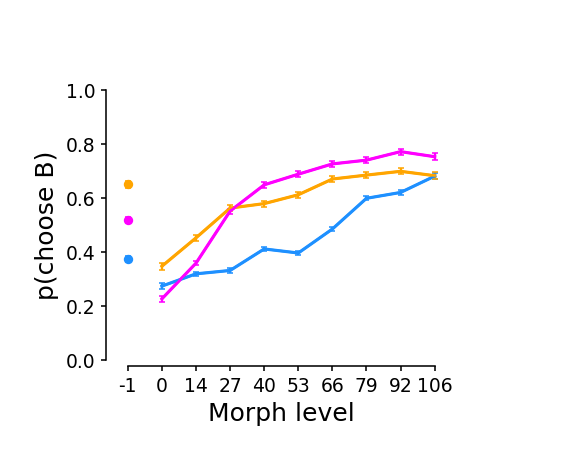

NameError: global name 'n_iterations' is not defined

In [101]:
dutils.default_morphcurves_avg_size(results, sdf, dst_dir=dst_dir, data_id=data_id, 
                                      train_str='%s_overlap-%.2f' % (train_str, overlap_thr))


# Train on subset, test on 1

In [329]:
# def plot_scores_by_test_set(results, ax=None):
#     if ax is None:
#         fig, ax = pl.subplots(dpi=dpi, figsize=(5,4), sharex=True, sharey=True)
#     sizes = [str(s) for s in sdf['size'].unique()]
#     markersize=5
#     for visual_area, vdf in results.groupby(['visual_area']):

#         mean_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).mean()[metric]
#         sem_vals = vdf[vdf['test_transform'].isin(sizes)].groupby(['test_transform']).sem()[metric]

#         ax.plot(np.arange(0, len(sizes)), mean_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=visual_area)
#         ax.errorbar(np.arange(0, len(sizes)), mean_vals, yerr=sem_vals, color=area_colors[visual_area],
#                    marker='o', markersize=markersize, label=None)

#         #ax.set_title(train_transform)
#         ax.axhline(y=0.5, color='k', linestyle=':')
#         ax.set_ylim([0.4, 1])
#         ax.set_xticks(np.arange(0, len(sizes)))
#         ax.set_xticklabels(sizes)

#     ax.set_xlabel('Test Size', fontsize=16)
#     ax.set_ylabel(metric, fontsize=16)
#     pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.3, wspace=0.3)
#     sns.despine(trim=True, offset=4)
#     ax.legend(bbox_to_anchor=(1, 1.1))
#     return ax

In [330]:
m0=0
m100=106
n_iterations=100
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
cv=True
cv_nfolds=5
C_value=None
test_split=0.2

(0, 106, '100 iters')


In [331]:
n_train_configs=4
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

Results exist, loading...
False


### Load or do

In [332]:
n_processes=1
if do_fit:
    r_list=[]
    for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):

        iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                                   test_generalization=True, single=False, n_train_configs=4,
                                   n_iterations=n_iterations, n_processes=n_processes)

        iterdf = pd.concat(iter_list, axis=0).reset_index(drop=True)

        add_info = {'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area}
        iterdf = putils.add_meta_to_df(iterdf, add_info)

        r_list.append(iterdf)

    results = pd.concat(r_list, axis=0).reset_index(drop=True)
    print(r_list[0].shape, results.shape)
    
    # Save
    print("Done!")
    with open(res_outfile, 'wb') as f:
        pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

    print("Saved to: %s" % res_outfile)


### plot

In [375]:
reload(dutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

<IPython.core.display.Javascript object>


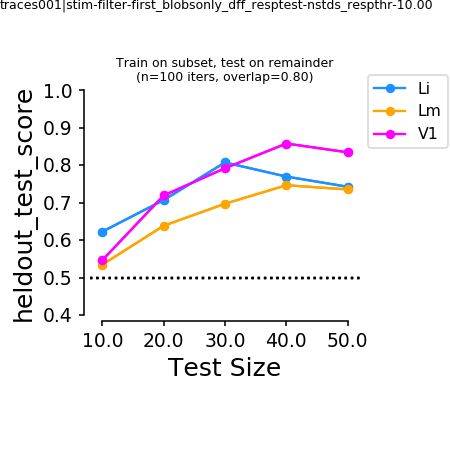

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size')


<IPython.core.display.Javascript object>


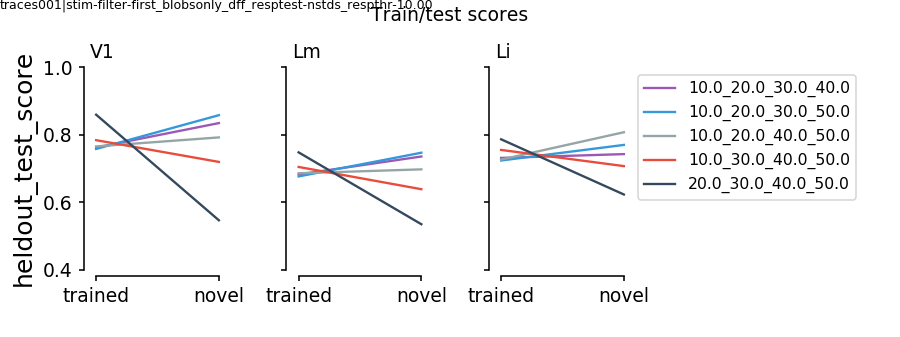

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained')


<IPython.core.display.Javascript object>


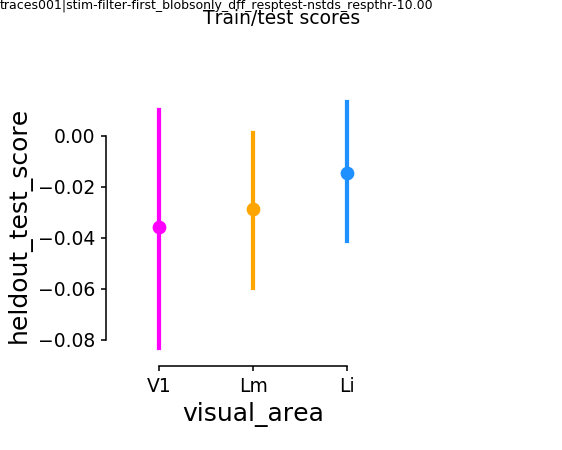

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap', 'train-4_sample-112_iter-100_heldout_test_score_overlap-0.80_generalize_size__avg-novel-v-trained-difference')


In [376]:


metric = 'heldout_test_score'
plot_str = '%s_%s_overlap-%.2f' % (train_str, metric, overlap_thr)
plot_title = "Train on subset, test on remainder\n(n=%i iters, overlap=%.2f)" % (n_iterations, overlap_thr)

dutils.default_train_test_subset(results, sdf, metric=metric, 
                                 plot_title=plot_title, plot_str=plot_str, dst_dir=overlap_dir, data_id=data_id)


# Test by N cells

In [ ]:
sample_ncells = 112

train_str = 'train-%i_sample-%i_iter-%i' % (n_train_configs, sample_ncells, n_iterations)

res_outfile = os.path.join(overlap_dir, '%s_results.pkl' % train_str)
do_fit = not os.path.exists(res_outfile)
if not do_fit:
    try:
        print("Results exist, loading...")
        with open(res_outfile, 'r') as f:
            results = pkl.load(f)
    except Exception as e:
        do_fit=True
print(do_fit)

In [314]:
r_list = []
for visual_area, vdf in results.groupby(['visual_area']):
    for train_transform, traindf in vdf.groupby(['train_transform']):
        t_sizes = [t for t in sizes if t!=train_transform]
        
        curr_train_vals = traindf[traindf['test_transform']==train_transform][metric].values
        curr_iters = traindf[traindf['test_transform']==train_transform]['iteration'].values
        for test_transform in t_sizes:
            curr_test_vals = traindf[traindf['test_transform']==test_transform][metric].values
            rel_scores = (curr_test_vals/curr_train_vals) #* curr_train_vals
            
            reldf = pd.DataFrame({metric: rel_scores,
                                  'iteration': curr_iters})
            
            add_info = {'visual_area': visual_area, 'train_transform': train_transform, 
                        'test_transform': test_transform}
            reldf = putils.add_meta_to_df(reldf, add_info)
            r_list.append(reldf)
relative_df = pd.concat(r_list, axis=0).reset_index(drop=True) 

In [315]:
relative_means = relative_df.groupby(['visual_area', 'train_transform', 'test_transform']).mean().reset_index()



<IPython.core.display.Javascript object>


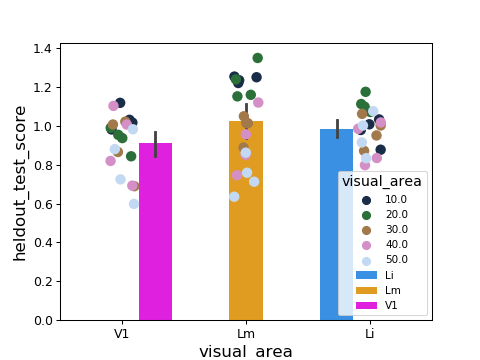

In [317]:
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, hue='train_transform', data=relative_means, ax=ax,
             order=visual_areas, palette='cubehelix', s=10)
sns.barplot(x='visual_area', y=metric, hue='visual_area', data=relative_means, ax=ax,
             order=visual_areas, palette=area_colors)

<IPython.core.display.Javascript object>


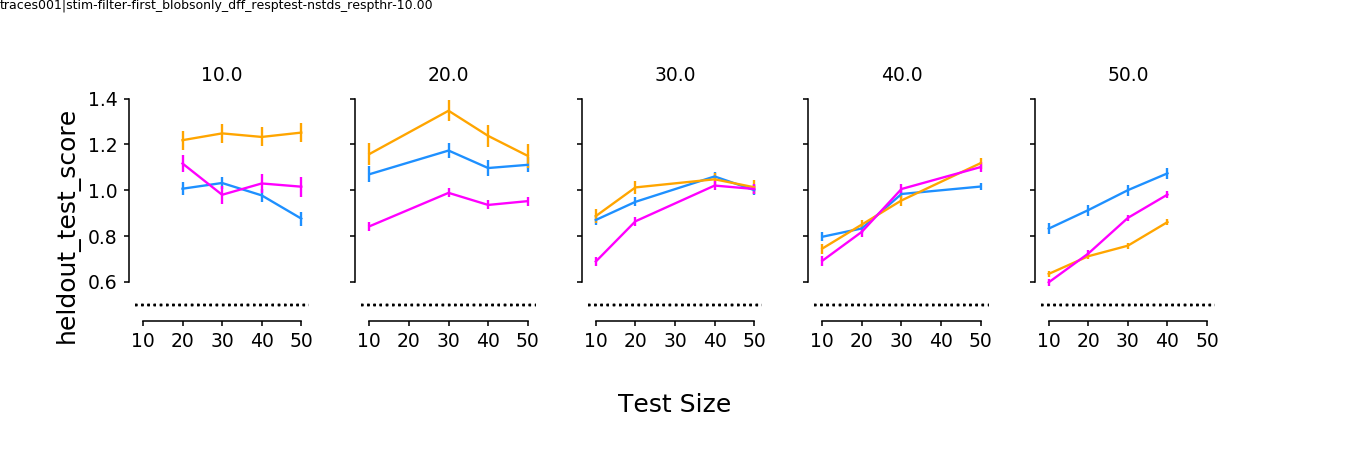

In [289]:
# Plot.

fig, axn = pl.subplots(1, 3, dpi=dpi, figsize=(12,4), sharex=True, sharey=True)

for visual_area, vdf in relative_df.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)

    mean_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).mean()[metric]
    sem_vals = vdf.groupby(['train_transform', 'test_transform']).mean().groupby(['train_transform']).sem()[metric]

    
        currdf = traindf.groupby(['test_transform']).mean().reset_index()
        currdf_sem = traindf.groupby(['test_transform']).sem().reset_index()

        xv = sorted(currdf['test_transform'].values)
        yv = currdf.sort_values(by='test_transform')['%s' % metric].values
        yv_err = currdf_sem.sort_values(by='test_transform')['%s' % metric].values

        #train_index = xv.index(train_transform)

        ax.errorbar(xv, yv, yerr=yv_err, color=area_colors[visual_area])
#         ax.errorbar(xv[train_index], yv[train_index], yerr=yv_err[train_index], color=area_colors[visual_area],
#                    marker='o', markersize=10)

        ax.set_title(train_transform)
        ax.axhline(y=0.5, color='k', linestyle=':')
        #ax.set_ylim([0.4, 1])
        ax.set_xticks(sizes)
        ax.set_xticklabels([int(s) for s in sizes])
    
fig.text(0.5, 0.1, 'Test Size', ha="center", va="center", fontsize=16)
fig.text(0.05,0.5, metric, ha="center", va="center", rotation=90, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.3, wspace=0.3)
sns.despine(trim=True, offset=4)

putils.label_figure(fig, data_id)

# figname = 'generalize_size_%s__ncells-%i_overlap-%.2f_%i-iter' % (metric, sample_ncells, overlap_thr, n_iterations)
# pl.savefig(os.path.join(overlap_dir, '%s.svg' % figname))
# print(overlap_dir, figname)

In [61]:
rfs_and_blobs[(rfs_and_blobs['datakey'].isin(stim_datakeys)) 
             & (rfs_and_blobs['perc_overlap']>=overlap_thr)][['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

V1    650
Lm    201
Li    127
Name: visual_area, dtype: int64

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



# Test generalization

In [38]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

NameError: name 'animalid' is not defined

In [1156]:
overlap_thr=0.8
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)


In [1230]:
from sklearn.model_selection import StratifiedKFold

In [1456]:
n_iterations = 3